In [0]:
https://docs.google.com/document/d/17LM1hM99Mn5UCJdBvitL7H1DYEwnTifvZbHkh__L2I8/edit?tab=t.0

In [0]:
%load_ext autoreload
%autoreload 2
!pip install gurobipy
from datetime import datetime, timedelta
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from IPython.display import display, clear_output
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 200)
pd.set_option('display.float_format', '{:.4f}'.format)
clear_output()

### load data

In [0]:
# set population as in Raleigh market
POPULATION = {'AkronOH': 1_260_000}

In [0]:
# load schedule data
FILE = 'Pairwise Duplication 2025-06-02[77].xlsm'
SELECT = {'market':'market', 'station':'channel', 'dow':'dow', 'daypart':'daypart', 'P18+ Impressions':'aqh_cost'}
keys = ['channel', 'dow', 'daypart']
origin = (pd.read_excel(FILE)[list(SELECT.keys())]
            .rename(columns=SELECT)
            .drop_duplicates(keys)
          )

channels = origin['channel'].drop_duplicates().to_list()
dow = origin['dow'].drop_duplicates().to_list()
dayparts = origin['daypart'].drop_duplicates().to_list()
print(f'channels: {len(channels)}, dow: {len(dow)}, dayparts: {len(dayparts)}, all: {len(origin)}')

channels: 5, dow: 7, dayparts: 5, all: 175


(<Axes: xlabel='cume', ylabel='Count'>, <Axes: xlabel='aqh', ylabel='Count'>)

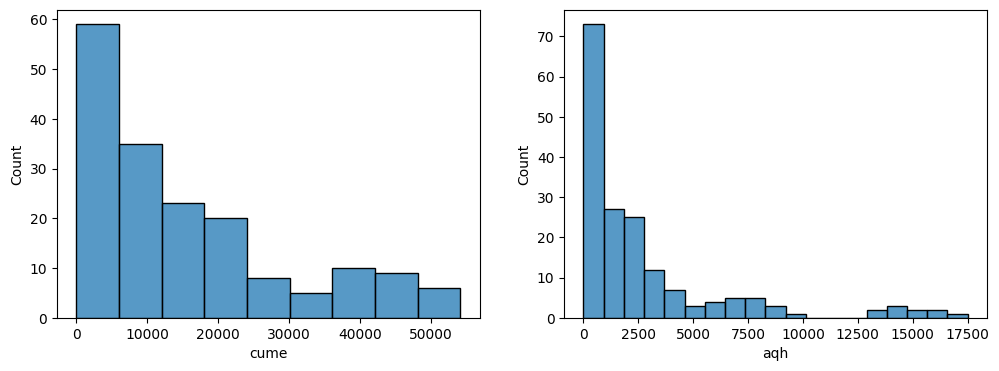

In [0]:
# load cume and aqh data
SELECT = {'Calls1':'channel', 'DOW1':'dow', 'Daypart':'daypart', 'Unrounded AQH':'aqh', 'Unrounded Cume':'cume'}
dow_map = {'MONDAY': 1, 'TUESDAY':2, 'WEDNESDAY':3, 'THURSDAY':4, 'FRIDAY':5, 'SATURDAY':6, 'SUNDAY':7}
cume_aqh = (pd.read_excel(FILE, sheet_name='Discrete')[list(SELECT.keys())]
              .rename(columns=SELECT)
              .assign(dow = lambda x: x['dow'].map(dow_map))
              .assign(aqh = lambda x: x['aqh'].astype(int))
              .assign(cume = lambda x: x['cume'].astype(int))
            )


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(cume_aqh['cume'], ax=axes[0]), sns.histplot(cume_aqh['aqh'], ax=axes[1])

In [0]:
# different channles names in origin and cume_aqh - replace channels names for simulation 
replace = { origin['channel'].unique()[index]: value for index, value in enumerate(cume_aqh['channel'].unique())}

In [0]:
# prepare data
pd.set_option('mode.use_inf_as_na', True)
ON = ['channel', 'dow', 'daypart']
data = (origin.assign(channel = lambda x: x['channel'].map(replace))
              .assign(obj = lambda x: x[['channel',  'dow', 'daypart']].astype(str).agg('_'.join, axis=1))
              .merge(cume_aqh, on=ON, how='left')
              .assign(cpm = lambda x: (x['aqh_cost'] / x['aqh']))
              .assign(cpm = lambda x:  x['cpm'].fillna(x['cpm'].mean()))
              .assign(population = lambda x: x['market'].map(POPULATION))
              .assign(reach = lambda x: x['cume'] / x['population']))

### build correlation table

In [0]:
# random correlation approach (not used)
np.random.seed(seed=42)
SELECT = ['market', 'obj']
corr_table = (data[SELECT].merge(data[SELECT], on='market', how='left')
             .loc[lambda x: ~(x['obj_x'] == x['obj_y'])]
             .assign(corr = lambda x: np.random.uniform(0.5, 0.7, len(x)))
)
corr_table

,market,obj_x,obj_y,corr
1,AkronOH,WDCG-F2_1_AMD,WDCG-F2_2_AMD,0.5749
2,AkronOH,WDCG-F2_1_AMD,WDCG-F2_3_AMD,0.6901
3,AkronOH,WDCG-F2_1_AMD,WDCG-F2_4_AMD,0.6464
4,AkronOH,WDCG-F2_1_AMD,WDCG-F2_5_AMD,0.6197
5,AkronOH,WDCG-F2_1_AMD,WDCG-F2_6_AMD,0.5312
...,...,...,...,...
30619,AkronOH,WTKK-FM_7_PMD,WTKK-FM_2_PMD,0.6998
30620,AkronOH,WTKK-FM_7_PMD,WTKK-FM_3_PMD,0.6342
30621,AkronOH,WTKK-FM_7_PMD,WTKK-FM_4_PMD,0.5811
30622,AkronOH,WTKK-FM_7_PMD,WTKK-FM_5_PMD,0.5151


In [0]:
# make a expert assumption by correaltion
np.random.seed(seed=42)
BASE_CORR = 0.05
SELECT = ['market', 'obj', 'channel', 'dow', 'daypart']
corr_table = (data[SELECT].merge(data[SELECT], on='market', how='left')
             .loc[lambda x: ~(x['obj_x'] == x['obj_y'])]
             .assign(channel_corr = lambda x: np.where(x['channel_x'] == x['channel_y'], 1, 0))
             .assign(dow_corr = lambda x: np.where(x['dow_x'] == x['dow_y'], 1, 0))
             .assign(daypart_corr = lambda x: np.where(x['daypart_x'] == x['daypart_y'], 1, 0))
             .assign(corr = lambda x: BASE_CORR + x['channel_corr'] * 0.3 + x['dow_corr']* 0.2 + x['daypart_corr'] * 0.1)
             .drop(['channel_corr', 'dow_corr', 'daypart_corr', 'channel_x', 'channel_y', 'dow_x', 'dow_y', 'daypart_x', 'daypart_y'], axis=1)
)
corr_table

,market,obj_x,obj_y,corr
1,AkronOH,WDCG-F2_1_AMD,WDCG-F2_2_AMD,0.4500
2,AkronOH,WDCG-F2_1_AMD,WDCG-F2_3_AMD,0.4500
3,AkronOH,WDCG-F2_1_AMD,WDCG-F2_4_AMD,0.4500
4,AkronOH,WDCG-F2_1_AMD,WDCG-F2_5_AMD,0.4500
5,AkronOH,WDCG-F2_1_AMD,WDCG-F2_6_AMD,0.4500
...,...,...,...,...
30619,AkronOH,WTKK-FM_7_PMD,WTKK-FM_2_PMD,0.4500
30620,AkronOH,WTKK-FM_7_PMD,WTKK-FM_3_PMD,0.4500
30621,AkronOH,WTKK-FM_7_PMD,WTKK-FM_4_PMD,0.4500
30622,AkronOH,WTKK-FM_7_PMD,WTKK-FM_5_PMD,0.4500


In [0]:
# take subset of data
data_len = len(data)
SHARE = 0.7
allow_matrix = np.random.uniform(0, 1, size=(data_len))  > SHARE

In [0]:
# build correlation matrix
# obj = channlel_dow_daypart
KEY = 'obj'
JOIN = 'market'
SELECT = [JOIN , KEY]
schedule = data[allow_matrix]
correlation_matrix = (schedule[SELECT].merge(schedule[SELECT], on=JOIN, how='left')
                                      .merge(corr_table, on=[KEY+'_x', KEY+'_y', 'market'], how='left')
                                      .assign(corr = lambda x: x['corr'].fillna(0))
                                      .pivot_table(index=KEY+'_x', columns=KEY+'_y', values='corr', fill_value=0, aggfunc='sum')
                      )
order_index = correlation_matrix.index

In [0]:
schedule

,market,channel,dow,daypart,aqh_cost,obj,aqh,cume,cpm,population,reach
0,AkronOH,WDCG-F2,1,AMD,603,WDCG-F2_1_AMD,290,1338,2.0793,1260000,0.0011
1,AkronOH,WDCG-F2,2,AMD,603,WDCG-F2_2_AMD,410,4200,1.4707,1260000,0.0033
3,AkronOH,WDCG-F2,4,AMD,603,WDCG-F2_4_AMD,725,5169,0.8317,1260000,0.0041
5,AkronOH,WDCG-F2,6,AMD,398,WDCG-F2_6_AMD,272,2506,1.4632,1260000,0.0020
6,AkronOH,WDCG-F2,7,AMD,216,WDCG-F2_7_AMD,386,2645,0.5596,1260000,0.0021
21,AkronOH,WDCG-F2,1,Overnight,56,WDCG-F2_1_Overnight,20,196,2.8000,1260000,0.0002
23,AkronOH,WDCG-F2,3,Overnight,56,WDCG-F2_3_Overnight,0,0,1.8312,1260000,0.0000
25,AkronOH,WDCG-F2,5,Overnight,56,WDCG-F2_5_Overnight,0,0,1.8312,1260000,0.0000
26,AkronOH,WDCG-F2,6,Overnight,18,WDCG-F2_6_Overnight,0,0,1.8312,1260000,0.0000
32,AkronOH,WDCG-F2,5,PMD,589,WDCG-F2_5_PMD,428,3850,1.3762,1260000,0.0031


In [0]:
# correlation matrix must be symmetric
def is_symmetric(matrix, tol=1e-8):
    return np.allclose(matrix, matrix.T, atol=tol)

if not is_symmetric(correlation_matrix): 
    print("make symmetric")
    make_symmetric = lambda x: x + x.T - np.diag(np.diag(x))
    correlation_matrix = make_symmetric(correlation_matrix)

In [0]:
SELECT = ['reach']

lambdas = (schedule.set_index('obj').reindex(order_index)
                   [SELECT].to_numpy().flatten())
corr = correlation_matrix.to_numpy()

In [0]:
lambdas.shape, corr.shape

((48,), (48, 48))

### Gurobi model - schedule optimisation. Poisson model - combined reach estimation 

#### Input

In [0]:
import gurobipy as gp

# reach (λ) 
lambdas = schedule[['reach']].to_numpy().flatten()

# Amount of posts
k = len(lambdas)

# listen duration (not used)
duration = 4 * 60
T = (schedule['aqh'] * duration / (schedule['cume'] )) * 60
T = T.fillna(T.mean()).to_numpy().flatten()

# Publication cost for each channel-dow-daypart
cost = schedule[['aqh_cost']].to_numpy().flatten()

# correlation matrix
C = corr

# Budget
budget = 20_000  
max_posts = 3

In [0]:
# show input data
print("reach:", lambdas[:10], f"shape {lambdas.shape}")
print('cost:', cost[:10], f"shape {cost.shape}")
print('Correlation matrix:', C[:5,:5], f"shape {C.shape}")
print('budget:', budget)
print('max_posts:', max_posts)

reach: [0.0010619  0.00333333 0.00410238 0.00198889 0.00209921 0.00015556
 0.         0.         0.         0.00305556] shape (48,)
cost: [603 603 603 398 216  56  56  56  18 589] shape (48,)
Correlation matrix: [[0.   0.55 0.45 0.35 0.45]
 [0.55 0.   0.35 0.45 0.35]
 [0.45 0.35 0.   0.35 0.45]
 [0.35 0.45 0.35 0.   0.35]
 [0.45 0.35 0.45 0.35 0.  ]] shape (48, 48)
budget: 20000
max_posts: 3


#### Poisson reach estimation

In [0]:
# check lambdas and corr constrains
def do_assert(lambdas, corr):
    """
    Проверяет корректность параметров lambdas и корреляционной матрицы corr.
    
    Параметры:
    ----------
    lambdas : array-like
        Массив интенсивностей для каждого канала (должны быть положительными)
    corr : 2D array-like
        Корреляционная матрица (должна быть симметричной, с 1 на диагонали,
        и положительно полуопределённой)
        
    Выбрасывает:
    -----------
    AssertionError
        Если параметры не проходят проверки
    """
    # Преобразуем в numpy массивы
    lambdas = np.asarray(lambdas)
    corr = np.asarray(corr)
    
    # Проверки для lambdas
    assert len(lambdas.shape) == 1, "lambdas должен быть 1D массивом"
    assert np.all(lambdas >= 0), "Все значения lambdas должны быть > 0"
    assert not np.any(np.isnan(lambdas)), "lambdas не должен содержать NaN"
    
    # Проверки для corr
    assert len(corr.shape) == 2, "corr должна быть 2D матрицей"
    assert corr.shape[0] == corr.shape[1], "corr должна быть квадратной матрицей"
    assert corr.shape[0] == len(lambdas), "Размер corr должен соответствовать количеству lambdas"
    
    # Проверка симметричности
    assert np.allclose(corr, corr.T), "Корреляционная матрица должна быть симметричной"
    
    # Проверка диагонали
    assert np.allclose(np.diag(corr), 1), "Диагональные элементы corr должны быть равны 1"
    
    # Проверка допустимых значений корреляции
    assert np.all(corr >= -1) and np.all(corr <= 1), "Корреляции должны быть в диапазоне [-1, 1]"
    
    # Проверка положительной полуопределённости (упрощённая)
    try:
        np.linalg.cholesky(corr + 1e-10*np.eye(len(corr)))
    except np.linalg.LinAlgError:
        assert False, "Корреляционная матрица должна быть положительно полуопределённой"
    
    print("Success")

def debug_plot(Z, Y, U, X, factor, debug=False):
    if debug:
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        axes = iter(axes.flatten())

        ax = next(axes)
        sns.scatterplot(x=Z[0], y=Z[1], ax=ax), ax.set_title("Z[0], Z[1] distribution")
        ax = next(axes)
        sns.scatterplot(x=Y[0], y=Y[1], ax=ax), ax.set_title("Y[0], Y[1] distribution")
        ax = next(axes)
        sns.scatterplot(x=U[0], y=U[1], ax=ax), ax.set_title("U[0], U[1] distribution")
        ax = next(axes)
        sns.histplot(x=(X.sum(axis=0) > 1+factor), ax=ax), ax.set_title("X distribution")
        plt.show()
    return 

In [0]:
from scipy.stats import norm, poisson
# fix correlation diag from zeros to ones
def fix_diag(corr):
    if np.sum(corr * np.eye(len(corr))) == 0:
        corr = corr + np.eye(len(corr))
        print("diag fixed")
    return corr

# Poisson reach simulation
def simulate_reach(lambdas, corr, T_active=None, T=4*3600, p_listen=0.2,  conservative_factor=0, n_draws=10_000, seed=0, debug=False):
    k = len(lambdas)
    lambdas = lambdas / p_listen
    rng = np.random.default_rng(seed)
    np.random.seed(seed)
    # 1. covariance & Cholesky
    corr = fix_diag(corr)
    do_assert(lambdas, corr)

    cov = np.outer(np.sqrt(lambdas), np.sqrt(lambdas)) * corr
    L = np.linalg.cholesky(cov + 1e-6*np.eye(k))   # jitter for PD
    # 2. Gaussian copula → Poisson
    Z = rng.standard_normal((k, n_draws))
    Y = L @ Z
    #    2.1 Normalization
    std_Y = np.std(Y, axis=1, keepdims=True)
    Y = Y / std_Y

    U = norm.cdf(Y)
    X = poisson.ppf(U, lambdas[:,None]).astype(int)

    # 3. Zero probability - some people don't listen to any channel
    # is_zero = np.random.rand(k, n_draws) > p_listen
    # X[is_zero] = 0

    # 4. Combined reach
    reach = (X.sum(axis=0) > 1 + conservative_factor * k).mean()
    debug_plot(Z=Z, Y=Y, U=U, X=X, factor=conservative_factor * k, debug=debug)
    return reach * p_listen

simulate_reach(lambdas, corr, T, debug=False) #* POPULATION['AkronOH']

diag fixed
Success


0.1184

#### Gurobi schedule optimisation

In [0]:
model = gp.Model("MediaOptimization")

model.setParam('MIPGap', 0.1)      # Приемлемая погрешность 10%
model.setParam('TimeLimit', 60)     # Максимум 1 минута
model.setParam('Heuristics', 0.05) # Минимум эвристик
model.setParam('Cuts', 0)           # Без отсечений

# Main variables
x = model.addVars(len(lambdas), vtype=gp.GRB.INTEGER, lb=0, ub=min(max_posts, 10), name="Posts")
reach = model.addVars(len(lambdas), name="Reach") 

# Audience intersection constrains min(reach[i], reach[j])
min_intersect = {}
for i in range(len(lambdas)):
    for j in range(i+1, len(lambdas)):
        min_ij = model.addVar(name=f"min_{i}_{j}")
        model.addGenConstrMin(min_ij, [reach[i], reach[j]], name=f"min_constr_{i}_{j}")
        min_intersect[(i,j)] = min_ij

# Target function taking into account unique coverage
unique_coef = 0.3
# Total reach 
total_reach = (sum(reach[j] for j in range(len(lambdas))) 
               - unique_coef * sum(min_intersect[(i,j)] * C[i,j] 
                                   for i in range(len(lambdas)) 
                                   for j in range(i+1, len(lambdas))
                                   )
               )

# Goal function
model.setObjective(total_reach, gp.GRB.MAXIMIZE)

N_dots = max_posts + 1
conservative_factor = 0.9

# Non-linear increment for reach: reach[j] = cume[j] * √x[j]
for j in range(len(lambdas)):
    x_points = list(range(N_dots + 1))
    y_points = [lambdas[j] * conservative_factor * (n)**(1/10) for n in x_points] 
    model.addGenConstrPWL(x[j], reach[j], x_points, y_points, f"PWL_Sqrt_{j}")

# No more than 150% of origin reach
for j in range(len(lambdas)):
    model.addConstr(reach[j] <= lambdas[j]* 1.5)

# no more than max_posts publication by channel-dow-daypart
for j in range(len(lambdas)):
    model.addConstr(x[j] <= max_posts)  

# Budget constrains
model.addConstr(sum(cost[j] * x[j] for j in range(len(lambdas))) <= budget)

# No more than N publication 
model.addConstr(sum(x[j] for j in range(len(lambdas))) <= len(lambdas) * 3)
model.optimize()

result = np.empty((len(lambdas),2))
# Show results
print("Amount of puplication optimisation:")
for j in range(len(lambdas)):
    print(f"Channel-dow-daypart schedule slot {j+1}: {int(x[j].X)} publications, reach = {reach[j].X:.3f}")
    result[j, 0] = x[j].X
    result[j, 1] = reach[j].X
print(f"Gurobi reach: {model.ObjVal:.3f}")

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 60
Set parameter Heuristics to value 0.05
Set parameter Cuts to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Platinum 8375C CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60
MIPGap  0.1
Cuts  0

Optimize a model with 98 rows, 1224 columns and 192 nonzeros
Model fingerprint: 0xfe76998a
Model has 1176 simple general constraints
  1128 MIN, 48 PWL
Variable types: 1176 continuous, 48 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [1e-02, 1e+00]
  Bounds range     [3e+00, 3e+00]
  RHS range        [2e-04, 2e+04]
  PWLCon x range   [1e+00, 3e+00]
  PWLCon y range   [0e+00, 4e-02]
Found heuristic solution: objective -0.0000000
Presolve added 4244 rows and 3117 columns
Presolve time: 0.05s


### Output (for budget = 20 000)

In [0]:
# show schedule optimisation result
df_plot = (schedule.assign(posts=result[:,0], reach_model=result[:,1])
#  .assign(budget = lambda x: x['population'] * x['reach'] / 1000 * x['cpm'])['budget'].sum()
# .assign(budget = lambda x: x['aqh_cost'] * x['posts'])#['budget'].sum()
# ['reach'].sum()
# .sort_values(['posts', 'reach'], ascending=False)

)
print('reach_without correlation (Gurobi model):', df_plot['reach_model'].sum(), "spots count:", df_plot['posts'].sum())
df_plot#.loc[lambda x: x['reach_model'] > 1e-5]

reach_without correlation (Gurobi model): 0.2252181181940699 spots count: 17.0


,market,channel,dow,daypart,aqh_cost,obj,aqh,cume,cpm,population,reach,posts,reach_model
0,AkronOH,WDCG-F2,1,AMD,603,WDCG-F2_1_AMD,290,1338,2.0793,1260000,0.0011,-0.0000,0.0000
1,AkronOH,WDCG-F2,2,AMD,603,WDCG-F2_2_AMD,410,4200,1.4707,1260000,0.0033,-0.0000,0.0000
3,AkronOH,WDCG-F2,4,AMD,603,WDCG-F2_4_AMD,725,5169,0.8317,1260000,0.0041,-0.0000,0.0000
5,AkronOH,WDCG-F2,6,AMD,398,WDCG-F2_6_AMD,272,2506,1.4632,1260000,0.0020,-0.0000,0.0000
6,AkronOH,WDCG-F2,7,AMD,216,WDCG-F2_7_AMD,386,2645,0.5596,1260000,0.0021,1.0000,0.0019
21,AkronOH,WDCG-F2,1,Overnight,56,WDCG-F2_1_Overnight,20,196,2.8000,1260000,0.0002,-0.0000,0.0000
23,AkronOH,WDCG-F2,3,Overnight,56,WDCG-F2_3_Overnight,0,0,1.8312,1260000,0.0000,0.0000,0.0000
25,AkronOH,WDCG-F2,5,Overnight,56,WDCG-F2_5_Overnight,0,0,1.8312,1260000,0.0000,-0.0000,0.0000
26,AkronOH,WDCG-F2,6,Overnight,18,WDCG-F2_6_Overnight,0,0,1.8312,1260000,0.0000,-0.0000,0.0000
32,AkronOH,WDCG-F2,5,PMD,589,WDCG-F2_5_PMD,428,3850,1.3762,1260000,0.0031,-0.0000,0.0000


In [0]:
# estimate combined reach based on optimial schedule
reach_model = df_plot['reach_model'].to_numpy().flatten()
reach = simulate_reach(reach_model, corr, T, debug=False) 
print("Reach share (Poisson reach estimation)", reach, "Absolute reach (Poisson reach estimation)", reach * POPULATION['AkronOH'])

diag fixed
Все проверки пройдены успешно!
Доля 0.058499999999999996 Абсолютные значения охвата 73710.0


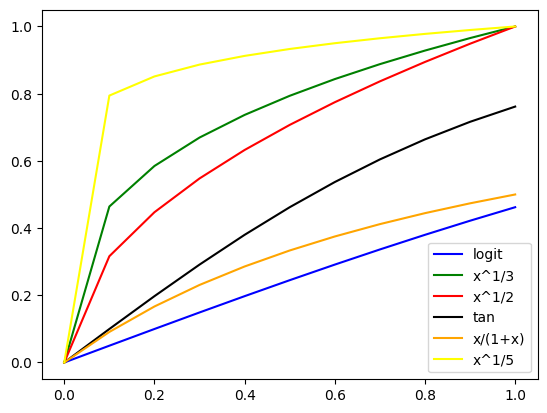

In [0]:
# non-linear reach increment visualisation
'''
    #[2 / (1 + np.exp(-lambdas[j] * n)) - 1 for n in x_points] 
    #[lambdas[j] * (n)**(1/3) for n in x_points]  
    #[(lambdas[j] * n) / (1 + lambdas[j] * n) for n in x_points]
    #[np.tanh(lambdas[j] * n) for n in x_points] 
    #[lambdas[j] * np.sqrt(n) for n in x_points]
'''
x_points = [0,0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1]
y_points = [2 / (1 + np.exp(- n)) - 1 for n in x_points]
sns.lineplot(x=x_points, y=y_points, color = 'blue', label = 'logit')
y_points = [ (n)**(1/3) for n in x_points]  
sns.lineplot(x=x_points, y=y_points, color = 'green', label = 'x^1/3')
y_points = [ np.sqrt(n) for n in x_points]
sns.lineplot(x=x_points, y=y_points, color = 'red', label = 'x^1/2')
y_points = [np.tanh( n) for n in x_points] 
sns.lineplot(x=x_points, y=y_points, color = 'black', label = 'tan')
y_points = [( n) / (1 + n) for n in x_points]
sns.lineplot(x=x_points, y=y_points, color = 'orange', label = 'x/(1+x)')
y_points = [ (n)**(1/10) for n in x_points]  
sns.lineplot(x=x_points, y=y_points, color = 'yellow', label = 'x^1/5')
plt.show()

In [0]:
# show differrence between non-linear function 
n = 3
j = 0 
print("x, n*x \t\t\t", lambdas[0], lambdas[0] * n)
print("1/1+x \t\t\t",  lambdas[j] * n /(1+lambdas[j] * n),  )
print("x^1/10 \t\t\t", lambdas[j] *  (n)**(1/10))
print("2 / (1 + exp(-x) - 1) \t", 2 / (1 + np.exp(-lambdas[0] * n)) - 1  )
print("x^1/10 \t\t\t", lambdas[j] * np.sqrt(n) )

x, n*x 			 0.0016666666666666668 0.005
1/1+x 			 0.0049751243781094535
x^1/10 			 0.0018602052900565074
2 / (1 + exp(-x) - 1) 	 0.002499994791679727
x^1/10 			 0.002886751345948129


### Optimisation (Full Pipeline)

In [0]:
# define Gurobi optimisation  function
def schedule_optimisation(lambdas, corr, budget, max_posts):
    model = gp.Model("MediaOptimization")

    model.setParam('MIPGap', 0.1)      # Приемлемая погрешность 10%
    model.setParam('TimeLimit', 60)     # Максимум 1 минута
    model.setParam('Heuristics', 0.05) # Минимум эвристик
    model.setParam('Cuts', 0)           # Без отсечений

    model = gp.Model("MediaOptimization")
    # Переменные
    x = model.addVars(len(lambdas), vtype=gp.GRB.INTEGER, lb=0, ub=min(max_posts, 10), name="Posts")
    reach = model.addVars(len(lambdas), name="Reach") 

    # Пересечение аудиторий через min(reach[i], reach[j])
    min_intersect = {}
    for i in range(len(lambdas)):
        for j in range(i+1, len(lambdas)):
            min_ij = model.addVar(name=f"min_{i}_{j}")
            model.addGenConstrMin(min_ij, [reach[i], reach[j]], name=f"min_constr_{i}_{j}")
            min_intersect[(i,j)] = min_ij

    # Целевая функция с учётом уникального охвата
    unique_coef = 0.3
    # Total reach 
    total_reach = (sum(reach[j] for j in range(len(lambdas))) 
                - unique_coef * sum(min_intersect[(i,j)] * C[i,j] 
                                    for i in range(len(lambdas)) 
                                    for j in range(i+1, len(lambdas))
                                    )
                )

    # Целевая функция: максимизировать охват
    model.setObjective(total_reach, gp.GRB.MAXIMIZE)

    N_dots = max_posts + 1
    conservative_factor = 0.9
    # Нелинейный прирост охвата: reach[j] = cume[j] * √x[j]
    for j in range(len(lambdas)):
        x_points = list(range(N_dots + 1))
        y_points = [lambdas[j] * conservative_factor * (n)**(1/10) for n in x_points] 
        model.addGenConstrPWL(x[j], reach[j], x_points, y_points, f"PWL_Sqrt_{j}")

    # Ни один канал не даст больше 150% от своего охвата
    for j in range(len(lambdas)):
        model.addConstr(reach[j] <= lambdas[j]* 1.5)#max(lambdas.flatten() * 1.5)) 

    # Не больше max_posts публикаций на канал
    for j in range(len(lambdas)):
        model.addConstr(x[j] <= max_posts)  

    # Ограничение на бюджет
    model.addConstr(sum(cost[j] * x[j] for j in range(len(lambdas))) <= budget)

    # не более N публикаций на все каналы
    model.addConstr(sum(x[j] for j in range(len(lambdas))) <= len(lambdas) * 3)

    model.optimize()

    result = np.empty((len(lambdas),2))
    # Вывод результатов
    print("Оптимальное количество публикаций:")
    for j in range(len(lambdas)):
        #print(f"Канал {j+1}: {int(x[j].X)} публикаций, охват = {reach[j].X:.3f}")
        result[j, 0] = x[j].X
        result[j, 1] = reach[j].X
    print(f"Общий охват: {model.ObjVal:.3f}")
    return result

####################################################### FULL Pipeline #######################################################
budget_increment = 5_000
budget_data = []
reach_data = []
schedule_data = []

# find optimal schedule for different budgets
for i in range(1, 20):
    # define budget
    budget =  budget_increment*i
    # find optimal schedule for current budget
    optimal_schedule = schedule_optimisation(lambdas=lambdas, corr=C, budget=budget, max_posts=3)
    # get lambdas from current budget
    reach_model = optimal_schedule[:, 1]
    # estimate combined reach based on optimial schedule 
    combined_reach = simulate_reach(reach_model, corr, debug=False) 
    # save data
    budget_data.append(budget)
    reach_data.append(combined_reach)
    schedule_data.append(optimal_schedule)

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 60
Set parameter Heuristics to value 0.05
Set parameter Cuts to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Platinum 8375C CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 98 rows, 1224 columns and 192 nonzeros
Model fingerprint: 0xb1c9e975
Model has 1176 simple general constraints
  1128 MIN, 48 PWL
Variable types: 1176 continuous, 48 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [1e-02, 1e+00]
  Bounds range     [3e+00, 3e+00]
  RHS range        [2e-04, 5e+04]
  PWLCon x range   [1e+00, 3e+00]
  PWLCon y range   [0e+00, 4e-02]
Found heuristic solution: objective -0.0000000
Presolve added 4244 rows and 3117 columns
Presolve time: 0.16s
Presolved: 4342 rows, 4341 columns, 11035 nonzeros
Variable

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

### Output

Text(0, 0.5, 'Reach')

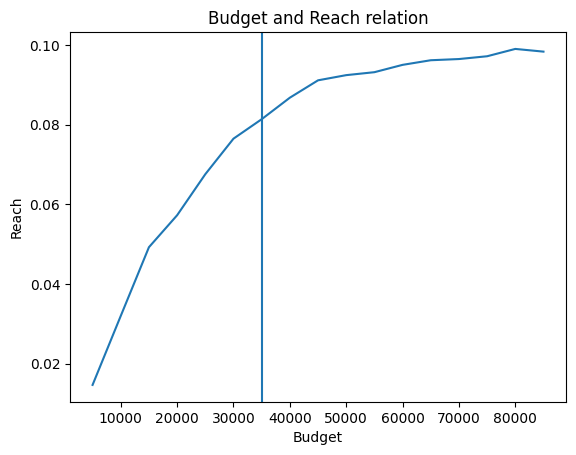

In [0]:
# plot budget and reach relation
ax = sns.lineplot(x=budget_data[:-2], y=np.array(reach_data[:-2]))
ax.axvline(x=budget_data[6], ymin=0, ymax=1)
ax.set_title("Budget and Reach relation")
ax.set_xlabel("Budget")
ax.set_ylabel("Reach")

In [0]:
# show optimal schedule for budget = 35_000
(schedule.assign(posts=schedule_data[6][:,0], reach_model=schedule_data[6][:,1])
.loc[lambda x: x['posts'] > 1e-5])

,market,channel,dow,daypart,aqh_cost,obj,aqh,cume,cpm,population,reach,posts,reach_model
0,AkronOH,WDCG-F2,1,AMD,603,WDCG-F2_1_AMD,290,1338,2.0793,1260000,0.0011,-0.0000,0.0000
1,AkronOH,WDCG-F2,2,AMD,603,WDCG-F2_2_AMD,410,4200,1.4707,1260000,0.0033,0.0000,0.0000
3,AkronOH,WDCG-F2,4,AMD,603,WDCG-F2_4_AMD,725,5169,0.8317,1260000,0.0041,1.0000,0.0037
5,AkronOH,WDCG-F2,6,AMD,398,WDCG-F2_6_AMD,272,2506,1.4632,1260000,0.0020,0.0000,0.0000
6,AkronOH,WDCG-F2,7,AMD,216,WDCG-F2_7_AMD,386,2645,0.5596,1260000,0.0021,1.0000,0.0019
21,AkronOH,WDCG-F2,1,Overnight,56,WDCG-F2_1_Overnight,20,196,2.8000,1260000,0.0002,-0.0000,0.0000
23,AkronOH,WDCG-F2,3,Overnight,56,WDCG-F2_3_Overnight,0,0,1.8312,1260000,0.0000,0.0000,0.0000
25,AkronOH,WDCG-F2,5,Overnight,56,WDCG-F2_5_Overnight,0,0,1.8312,1260000,0.0000,0.0000,0.0000
26,AkronOH,WDCG-F2,6,Overnight,18,WDCG-F2_6_Overnight,0,0,1.8312,1260000,0.0000,0.0000,0.0000
32,AkronOH,WDCG-F2,5,PMD,589,WDCG-F2_5_PMD,428,3850,1.3762,1260000,0.0031,0.0000,0.0000


In [0]:
# show combined reach
combined_reach[6]

0.0817

# OLD

### old

In [0]:
model = gp.Model("MediaOptimization")

model.setParam('MIPGap', 0.1)      # Приемлемая погрешность 10%
model.setParam('TimeLimit', 60)     # Максимум 1 минута
model.setParam('Heuristics', 0.05) # Минимум эвристик
model.setParam('Cuts', 0)           # Без отсечений

# Переменные
x = model.addVars(len(lambdas), vtype=gp.GRB.INTEGER, lb=0, ub=min(max_posts, 10), name="Posts")
reach = model.addVars(len(lambdas), name="Reach") 

# Целевая функция с учётом уникального охвата
unique_coef = 5
total_reach = (sum(reach[j] for j in range(len(lambdas))) - 
              unique_coef * sum(reach[i]*reach[j]*C[i,j] 
                                for i in range(len(lambdas)) 
                                for j in range(i+1, len(lambdas))))

# Целевая функция: максимизировать охват
model.setObjective(total_reach, gp.GRB.MAXIMIZE)

N_dots = 10
conservative_factor = 0.8
# Нелинейный охват: reach[j] = cume[j] * √x[j]
for j in range(len(lambdas)):
    x_points = list(range(N_dots + 1))
    y_points = [conservative_factor*(lambdas[j] * n) / (1 + lambdas[j] * n) for n in x_points] #[lambdas[j] * conservative_factor * (n)**(1/5) for n in x_points] 
    model.addGenConstrPWL(x[j], reach[j], x_points, y_points, f"PWL_Sqrt_{j}")

# Ни один канал не даст больше 150% от своего охвата
for j in range(len(lambdas)):
    model.addConstr(reach[j] <= lambdas[j]* 1.5)#max(lambdas.flatten() * 1.5)) 

# Не больше max_posts публикаций на канал
for j in range(len(lambdas)):
    model.addConstr(x[j] <= max_posts)  

# Ограничение на бюджет
model.addConstr(sum(cost[j] * x[j] for j in range(len(lambdas))) <= budget)

# не более N публикаций на все каналы
model.addConstr(sum(x[j] for j in range(len(lambdas))) <= len(lambdas) )

model.optimize()

result = np.empty((len(lambdas),2))
# Вывод результатов
print("Оптимальное количество публикаций:")
for j in range(len(lambdas)):
    print(f"Канал {j+1}: {int(x[j].X)} публикаций, охват = {reach[j].X:.3f}")
    result[j, 0] = x[j].X
    result[j, 1] = reach[j].X
print(f"Общий охват: {model.ObjVal:.3f}")

In [0]:
model = gp.Model("MediaOptimization")

# Переменные
x = model.addVars(len(lambdas), vtype=gp.GRB.INTEGER, lb=min_posts, ub=max_posts, name="Posts")
reach = model.addVars(len(lambdas), name="Reach")  # P_j = 1 - exp(-λ_j * x_j)

N_dots = 4
# Кусочно-линейная аппроксимация для P_j
for j in range(len(lambdas)):
    x_points = list(range(N_dots + 1))
    y_points = [1 - np.exp(-lambdas[j] * n) for n in x_points]
    model.addGenConstrPWL(x[j], reach[j], x_points, y_points)

# Линейная часть целевой функции: сумма P_j
linear_part = sum(reach[j] for j in range(len(lambdas)))

# Квадратичная поправка: сумма P_i * P_j * ρ_ij
quad_correction = 0
for i in range(len(lambdas)):
    for j in range(i + 1, len(lambdas)):
        quad_correction += reach[i] * reach[j] * C[i, j]

# Общий охват: linear_part - quad_correction
total_reach = linear_part - quad_correction

# Целевая функция: максимизировать охват
model.setObjective(total_reach, gp.GRB.MAXIMIZE)

# Ограничение на бюджет
model.addConstr(sum(cost[j] * x[j] for j in range(len(lambdas))) <= budget)

model.optimize()

result = np.empty((len(lambdas),2))
# Вывод результатов
print("Оптимальное количество публикаций:")
for j in range(len(lambdas)):
    print(f"Канал {j+1}: {int(x[j].X)} публикаций, охват = {reach[j].X:.3f}")
    result[j, 0] = x[j].X
    result[j, 1] = reach[j].X
print(f"Общий охват: {model.ObjVal:.3f}")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: Intel(R) Xeon(R) Platinum 8375C CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 90 columns and 45 nonzeros
Model fingerprint: 0x233047b6
Model has 990 quadratic objective terms
Model has 45 simple general constraints
  45 PWL
Variable types: 45 continuous, 45 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-02, 2e+01]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-01, 1e+00]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+04, 1e+04]
  PWLCon x range   [1e+00, 3e+00]
  PWLCon y range   [0e+00, 1e-01]
Presolve added 131 rows and 174 columns
Presolve time: 0.00s
Presolved: 2025 rows, 1212 columns, 7154 nonzeros
Presolved model has 44 SOS constraint(s)
Presolved model has 946 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 1168 conti

In [0]:
(schedule.assign(posts=result[:,0], reach_=result[:,1])
#  .assign(budget = lambda x: x['population'] * x['reach'] / 1000 * x['cpm'])['budget'].sum()
# ['reach'].sum()
.sort_values(['posts', 'reach'], ascending=False)
)

,market,channel,dow,daypart,aqh_cost,obj,aqh,cume,cpm,population,reach,posts,reach_
157,AkronOH,WTKK-FM,4,Midday,3399,WTKK-FM_4_Midday,14273,54101,0.2381,1260000,0.0429,2.0000,0.0633
156,AkronOH,WTKK-FM,3,Midday,3399,WTKK-FM_3_Midday,15082,51305,0.2254,1260000,0.0407,2.0000,0.0602
170,AkronOH,WTKK-FM,3,PMD,3434,WTKK-FM_3_PMD,9487,46778,0.3620,1260000,0.0371,2.0000,0.0553
107,AkronOH,WDCG-FM,3,AMD,4174,WDCG-FM_3_AMD,6455,45239,0.6466,1260000,0.0359,2.0000,0.0536
136,AkronOH,WDCG-FM,4,PMD,2946,WDCG-FM_4_PMD,6534,42217,0.4509,1260000,0.0335,2.0000,0.0502
154,AkronOH,WTKK-FM,1,Midday,3399,WTKK-FM_1_Midday,13910,42109,0.2444,1260000,0.0334,2.0000,0.0501
137,AkronOH,WDCG-FM,5,PMD,2946,WDCG-FM_5_PMD,8490,41699,0.3470,1260000,0.0331,1.0000,0.0256
172,AkronOH,WTKK-FM,5,PMD,3434,WTKK-FM_5_PMD,7553,41468,0.4547,1260000,0.0329,1.0000,0.0255
134,AkronOH,WDCG-FM,2,PMD,2946,WDCG-FM_2_PMD,8245,38854,0.3573,1260000,0.0308,1.0000,0.0239
169,AkronOH,WTKK-FM,2,PMD,3434,WTKK-FM_2_PMD,7960,38339,0.4314,1260000,0.0304,1.0000,0.0236


## Attempt 1

In [0]:
print('correlation matrix shape: ', corr.shape, 'reach shape:', lambdas.shape)
import numpy as np
from scipy.stats import norm, poisson
from scipy.linalg import ldl

def modified_cholesky(A):
    L, D, perm = ldl(A, hermitian=True)
    D = np.diag(D)
    D = np.maximum(D, 1e-12)
    return L @ np.diag(np.sqrt(D))

def nearest_pd(A):
    """Находит ближайшую положительно определённую матрицу"""
    B = (A + A.T) / 2
    _, s, V = np.linalg.svd(B)
    H = V.T @ np.diag(s) @ V
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    return A3


def simulate_reach(lambdas, corr, n_draws=200_000, seed=0):
    k = len(lambdas)
    rng = np.random.default_rng(seed)
    # 1. covariance & Cholesky
    cov = np.outer(np.sqrt(lambdas), np.sqrt(lambdas)) * corr
    cov = nearest_pd(cov)
    L = np.linalg.cholesky(cov + 1e-12*np.eye(k))  # jitter for PD
    # 2. Gaussian copula → Poisson
    Z = rng.standard_normal((k, n_draws))
    Y = L @ Z
    U = norm.cdf(Y)
    X = poisson.ppf(U, lambdas[:,None]).astype(int)
    # 3. Combined reach
    reach = (X.sum(axis=0) > 0).mean()
    return reach

# example
print(simulate_reach(lambdas, corr))

correlation matrix shape:  (175, 175) reach shape: (175,)
0.0


In [0]:
import numpy as np
from scipy.stats import norm, poisson

def simulate_reach(lambdas, corr, n_draws=200_000, seed=0):
    k = len(lambdas)
    rng = np.random.default_rng(seed)
    # 1. covariance & Cholesky
    cov = np.outer(np.sqrt(lambdas), np.sqrt(lambdas)) * corr
    L = np.linalg.cholesky(cov + 1e-12*np.eye(k))   # jitter for PD
    # 2. Gaussian copula → Poisson
    Z = rng.standard_normal((k, n_draws))
    Y = L @ Z
    U = norm.cdf(Y)
    X = poisson.ppf(U, lambdas[:,None]).astype(int)
    # 3. Combined reach
    reach = (X.sum(axis=0) > 0).mean()
    return reach

# example
lambdas = np.array([0.15, 0.10, 0.08])   # channel means
corr     = np.array([[1, .50, .55],
                     [.50, 1, .55],
                     [.55, .55, 1]])
print(simulate_reach(lambdas, corr))

0.002575


In [0]:
sum(lambdas * 1_000_000), 5.5e-05 * 1_000_000

(2675993.0, 55.0)

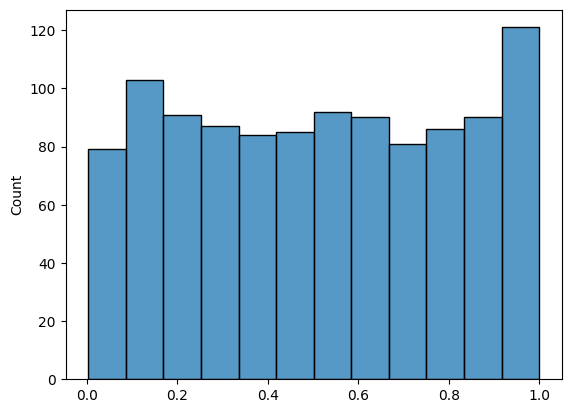

<Axes: ylabel='Count'>

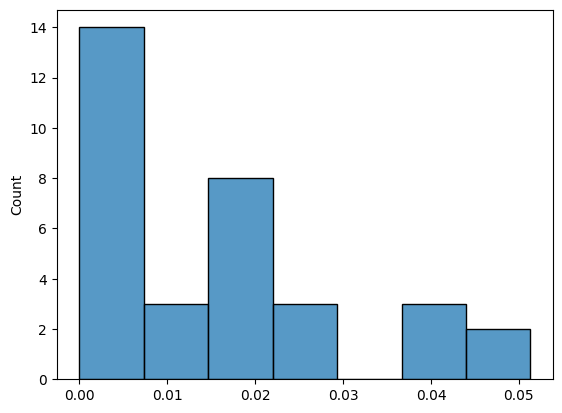

In [0]:
sns.histplot(corr.flatten())
plt.show()
sns.histplot(lambdas.flatten())

In [0]:
eps = 0.001
corr_matrix = (data.assign(cpm = lambda x: x['aqh_cost'] / x['aqh'])
     .merge(data.drop(columns=['aqh_cost']), on=['market'], how='left')
     .loc[lambda x: ~((x['channel_x'] == x['channel_y']) & (x['dow_x'] == x['dow_y']) & (x['daypart_x'] == x['daypart_y']))]
     .assign(aqh_min = lambda x: np.minimum(x['aqh_x'], x['aqh_y']))
     .assign(rnd = lambda x: np.random.uniform(0.01, 1, len(x)))
     .assign(aqh_pairvise = lambda x: (x['rnd'] * x['aqh_min']).astype(int))
     .assign(duplication_prc = lambda x: x['aqh_pairvise'] / x['aqh_min'] )
     .assign(adh_combined = lambda x: x['aqh_x'] + x['aqh_y'])
     .assign(combined_cume = lambda x: x['cume_x'] + x['cume_y'])
     .assign(corr = lambda x: x['duplication_prc'] )
     .assign(x = lambda x: x[['channel_x',  'dow_x', 'daypart_x']].astype(str).agg('_'.join, axis=1) )
     .assign(y = lambda x: x[['channel_y',  'dow_y', 'daypart_y']].astype(str).agg('_'.join, axis=1) )
     [['x', 'y', 'corr']]
     .pivot_table(index='x', columns='y', values='corr', fill_value=1, aggfunc='sum')
     .apply(lambda x: np.where(x==0, eps, x))
)
corr_matrix

y,WDCG-F2_1_AMD,WDCG-F2_1_Evening,WDCG-F2_1_Midday,WDCG-F2_1_Overnight,WDCG-F2_1_PMD,WDCG-F2_2_AMD,WDCG-F2_2_Evening,WDCG-F2_2_Midday,WDCG-F2_2_Overnight,WDCG-F2_2_PMD,WDCG-F2_3_AMD,WDCG-F2_3_Evening,WDCG-F2_3_Midday,WDCG-F2_3_Overnight,WDCG-F2_3_PMD,WDCG-F2_4_AMD,WDCG-F2_4_Evening,WDCG-F2_4_Midday,WDCG-F2_4_Overnight,WDCG-F2_4_PMD,WDCG-F2_5_AMD,WDCG-F2_5_Evening,WDCG-F2_5_Midday,WDCG-F2_5_Overnight,WDCG-F2_5_PMD,WDCG-F2_6_AMD,WDCG-F2_6_Evening,WDCG-F2_6_Midday,WDCG-F2_6_Overnight,WDCG-F2_6_PMD,WDCG-F2_7_AMD,WDCG-F2_7_Evening,WDCG-F2_7_Midday,WDCG-F2_7_Overnight,WDCG-F2_7_PMD,WDCG-FM_1_AMD,WDCG-FM_1_Evening,WDCG-FM_1_Midday,WDCG-FM_1_Overnight,WDCG-FM_1_PMD,WDCG-FM_2_AMD,WDCG-FM_2_Evening,WDCG-FM_2_Midday,WDCG-FM_2_Overnight,WDCG-FM_2_PMD,WDCG-FM_3_AMD,WDCG-FM_3_Evening,WDCG-FM_3_Midday,WDCG-FM_3_Overnight,WDCG-FM_3_PMD,WDCG-FM_4_AMD,WDCG-FM_4_Evening,WDCG-FM_4_Midday,WDCG-FM_4_Overnight,WDCG-FM_4_PMD,WDCG-FM_5_AMD,WDCG-FM_5_Evening,WDCG-FM_5_Midday,WDCG-FM_5_Overnight,WDCG-FM_5_PMD,WDCG-FM_6_AMD,WDCG-FM_6_Evening,WDCG-FM_6_Midday,WDCG-FM_6_Overnight,WDCG-FM_6_PMD,WDCG-FM_7_AMD,WDCG-FM_7_Evening,WDCG-FM_7_Midday,WDCG-FM_7_Overnight,WDCG-FM_7_PMD,WNCB-FM_1_AMD,WNCB-FM_1_Evening,WNCB-FM_1_Midday,WNCB-FM_1_Overnight,WNCB-FM_1_PMD,WNCB-FM_2_AMD,WNCB-FM_2_Evening,WNCB-FM_2_Midday,WNCB-FM_2_Overnight,WNCB-FM_2_PMD,WNCB-FM_3_AMD,WNCB-FM_3_Evening,WNCB-FM_3_Midday,WNCB-FM_3_Overnight,WNCB-FM_3_PMD,WNCB-FM_4_AMD,WNCB-FM_4_Evening,WNCB-FM_4_Midday,WNCB-FM_4_Overnight,WNCB-FM_4_PMD,WNCB-FM_5_AMD,WNCB-FM_5_Evening,WNCB-FM_5_Midday,WNCB-FM_5_Overnight,WNCB-FM_5_PMD,WNCB-FM_6_AMD,WNCB-FM_6_Evening,WNCB-FM_6_Midday,WNCB-FM_6_Overnight,WNCB-FM_6_PMD,WNCB-FM_7_AMD,WNCB-FM_7_Evening,WNCB-FM_7_Midday,WNCB-FM_7_Overnight,WNCB-FM_7_PMD,WRDU-FM_1_AMD,WRDU-FM_1_Evening,WRDU-FM_1_Midday,WRDU-FM_1_Overnight,WRDU-FM_1_PMD,WRDU-FM_2_AMD,WRDU-FM_2_Evening,WRDU-FM_2_Midday,WRDU-FM_2_Overnight,WRDU-FM_2_PMD,WRDU-FM_3_AMD,WRDU-FM_3_Evening,WRDU-FM_3_Midday,WRDU-FM_3_Overnight,WRDU-FM_3_PMD,WRDU-FM_4_AMD,WRDU-FM_4_Evening,WRDU-FM_4_Midday,WRDU-FM_4_Overnight,WRDU-FM_4_PMD,WRDU-FM_5_AMD,WRDU-FM_5_Evening,WRDU-FM_5_Midday,WRDU-FM_5_Overnight,WRDU-FM_5_PMD,WRDU-FM_6_AMD,WRDU-FM_6_Evening,WRDU-FM_6_Midday,WRDU-FM_6_Overnight,WRDU-FM_6_PMD,WRDU-FM_7_AMD,WRDU-FM_7_Evening,WRDU-FM_7_Midday,WRDU-FM_7_Overnight,WRDU-FM_7_PMD,WTKK-FM_1_AMD,WTKK-FM_1_Evening,WTKK-FM_1_Midday,WTKK-FM_1_Overnight,WTKK-FM_1_PMD,WTKK-FM_2_AMD,WTKK-FM_2_Evening,WTKK-FM_2_Midday,WTKK-FM_2_Overnight,WTKK-FM_2_PMD,WTKK-FM_3_AMD,WTKK-FM_3_Evening,WTKK-FM_3_Midday,WTKK-FM_3_Overnight,WTKK-FM_3_PMD,WTKK-FM_4_AMD,WTKK-FM_4_Evening,WTKK-FM_4_Midday,WTKK-FM_4_Overnight,WTKK-FM_4_PMD,WTKK-FM_5_AMD,WTKK-FM_5_Evening,WTKK-FM_5_Midday,WTKK-FM_5_Overnight,WTKK-FM_5_PMD,WTKK-FM_6_AMD,WTKK-FM_6_Evening,WTKK-FM_6_Midday,WTKK-FM_6_Overnight,WTKK-FM_6_PMD,WTKK-FM_7_AMD,WTKK-FM_7_Evening,WTKK-FM_7_Midday,WTKK-FM_7_Overnight,WTKK-FM_7_PMD
x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WDCG-F2_1_AMD,1.0000,0.9306,0.9069,0.4500,0.3207,0.5103,0.9878,0.2310,0.0010,0.3276,0.9724,0.3200,0.6862,0.0010,0.4310,0.3345,0.4052,0.0207,0.7250,0.0655,0.1034,0.3036,0.6241,0.0010,0.1759,0.2096,0.6241,0.6931,0.0010,0.8828,0.9552,0.4149,0.5517,0.2459,0.9621,0.2241,0.2207,0.2621,0.8941,0.3552,0.7069,0.1000,0.9655,0.5217,0.5483,0.0828,0.7345,0.2483,0.6854,0.3517,0.7483,0.5724,0.6448,0.4074,0.5414,0.0379,0.5966,0.6448,0.7021,0.3621,0.1069,0.8207,0.2379,0.2429,0.9517,0.9241,0.9862,0.4621,0.2593,0.1897,0.4138,0.6172,0.6241,0.4932,0.1241,0.1966,0.8345,0.3621,0.3191,0.6276,0.2172,0.8897,0.2069,0.0010,0.6069,0.8724,0.9793,0.9759,0.5513,0.5793,0.9759,0.9931,0.2000,0.3310,0.5586,0.6793,0.2000,0.8552,0.4552,0.9241,0.7586,0.9552,0.0655,0.5207,0.1586,0.7483,0.1828,0.0103,0.6552,0.9552,0.0207,0.9138,0.6207,0.7909,0.4966,0.3207,0.5931,0.5793,0.0588,0.5724,0.4862,0.8345,0.5897,0.5697,0.0345,0.0862,0.3172,0.7483,0.9359

In [0]:
lambda_data = (data.assign(population = lambda x: x['market'].map(POPULATION))#
     .assign(lmd = lambda x: x['cume'] / x['population'])
     .assign(x = lambda x: x[['channel',  'dow', 'daypart']].astype(str).agg('_'.join, axis=1) )
     .set_index('x')
     .reindex(corr_matrix.index)
     [['lmd']]
 )
lambda_data

,lmd
x,
WDCG-F2_1_AMD,0.0013
WDCG-F2_1_Evening,0.0006
WDCG-F2_1_Midday,0.0026
WDCG-F2_1_Overnight,0.0002
WDCG-F2_1_PMD,0.0056
WDCG-F2_2_AMD,0.0042
WDCG-F2_2_Evening,0.0019
WDCG-F2_2_Midday,0.0047
WDCG-F2_2_Overnight,0.0000


array([[1.        , 0.38728324, 0.10689655, ..., 0.50689655, 0.96551724,
        0.31034483],
       [0.04624277, 1.        , 0.05202312, ..., 0.51445087, 0.54913295,
        0.80346821],
       [0.98275862, 0.44508671, 1.        , ..., 0.29262087, 0.5216285 ,
        0.42748092],
       ...,
       [0.95172414, 0.8265896 , 0.11959288, ..., 1.        , 0.93269231,
        0.87122736],
       [0.01724138, 0.89595376, 0.82442748, ..., 0.55769231, 1.        ,
        0.42253521],
       [0.09310345, 0.94797688, 0.35114504, ..., 0.65995976, 0.23742455,
        1.        ]])

In [0]:
import numpy as np
from scipy.stats import norm, poisson

def simulate_reach(lambdas, corr, n_draws=200_000, seed=0):
    k = len(lambdas)
    rng = np.random.default_rng(seed)
    # 1. covariance & Cholesky
    cov = np.outer(np.sqrt(lambdas), np.sqrt(lambdas)) * corr
    L = np.linalg.cholesky(cov + 1e-12*np.eye(k))   # jitter for PD
    # 2. Gaussian copula → Poisson
    Z = rng.standard_normal((k, n_draws))
    Y = L @ Z
    U = norm.cdf(Y)
    X = poisson.ppf(U, lambdas[:,None]).astype(int)
    # 3. Combined reach
    reach = (X.sum(axis=0) > 0).mean()
    return reach

# example
lambdas = lambda_data.to_numpy()
corr    = corr_matrix.to_numpy()
print(simulate_reach(lambdas, corr))

---------------------------------------------------------------------------
LinAlgError                               Traceback (most recent call last)
File <command-7859237089060679>, line 22
     20 lambdas = lambda_data.to_numpy()
     21 corr    = corr_matrix.to_numpy()
---> 22 print(simulate_reach(lambdas, corr))

File <command-7859237089060679>, line 9, in simulate_reach(lambdas, corr, n_draws, seed)
      7 # 1. covariance & Cholesky
      8 cov = np.outer(np.sqrt(lambdas), np.sqrt(lambdas)) * corr
----> 9 L = np.linalg.cholesky(cov + 1e-12*np.eye(k))   # jitter for PD
     10 # 2. Gaussian copula → Poisson
     11 Z = rng.standard_normal((k, n_draws))

File <__array_function__ internals>:180, in cholesky(*args, **kwargs)

File /databricks/python/lib/python3.11/site-packages/numpy/linalg/linalg.py:770, in cholesky(a)
    768 t, result_t = _commonType(a)
    769 signature = 'D->D' if isComplexType(t) else 'd->d'
--> 770 r = gufunc(a, signature=signature, extobj=extobj)
    771 re